In this notebook we try and get a basic adaptive thresholding method going.

In [1]:
import torch
from flytracker import run

from flytracker.utils.param_helpers import load_frame, test_mask, test_threshold
from skimage.filters import threshold_local

import matplotlib.pyplot as plt



%load_ext autoreload
%autoreload 2

In [2]:
# Location of movie
movie_path = "../../data/experiments/bruno/videos/seq_1.mp4"
image = load_frame(movie_path, frame=100, color=False)

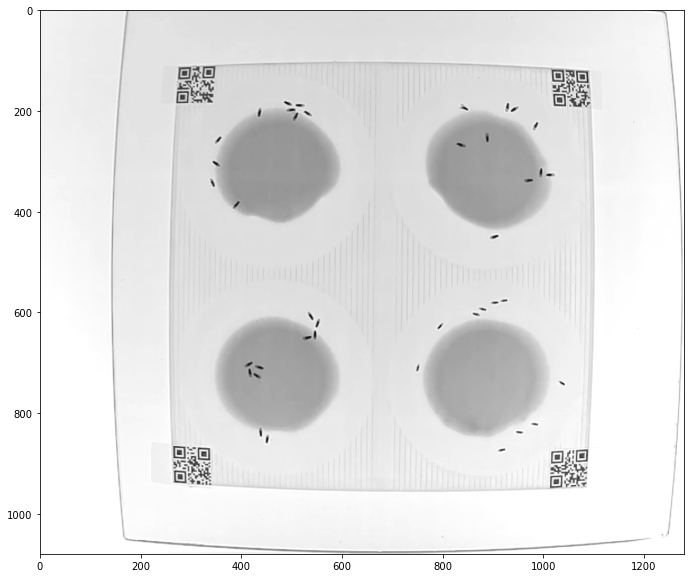

In [3]:
plt.figure(figsize=(15, 10))
plt.imshow(image, cmap='gray')

Let's define the mask:

In [4]:
mask = torch.ones((1080, 1280), dtype=bool)
mask[:130, :] = 0
mask[-160:, :] = 0
mask[:, :270] = 0
mask[:, -205:] = 0

mask[:190, :350] = 0
mask[:195, -270:] = 0
mask[-220:, :340] = 0
mask[870:, 1010:] = 0

masked_image = test_mask(image, mask)

Let's see how it looks;

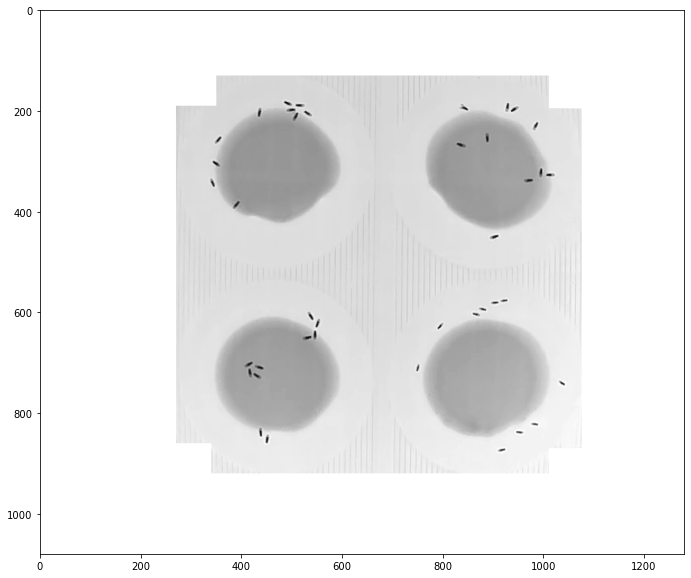

In [12]:
plt.figure(figsize=(15, 10))
plt.imshow(masked_image, cmap='gray')

# Baseline - global threshold

We start with our baseline method, a simple preset threshold:

In [6]:
from skimage.util import invert

In [7]:
threshold = 120
thresholded_image = test_threshold(masked_image, threshold)

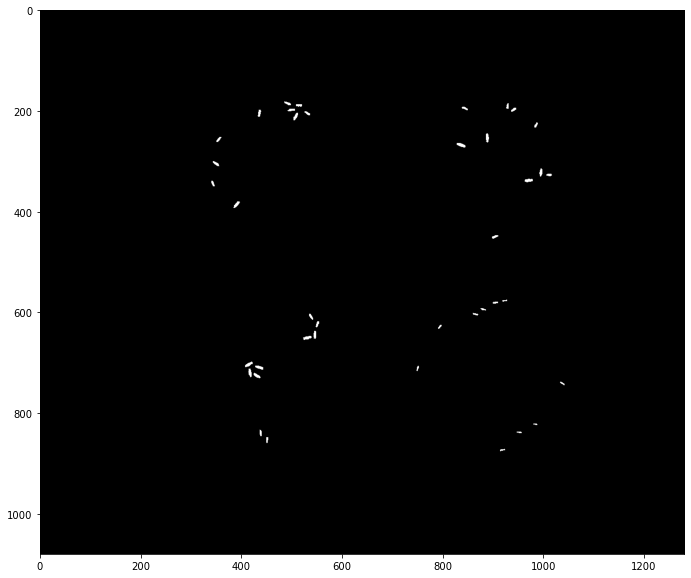

In [8]:
plt.figure(figsize=(15, 10))
plt.imshow(thresholded_image, cmap='gray')

Not bad, but the flies in the lower right corner for example are much smaller than those in in the lower left. We can fix that using an adaptive threshold. Since our lighting remains *mostly* constant, we only need to do the blurring once. Let's first check how well sk image does and then we'll implement our own.

In [9]:
from skimage.filters import threshold_local

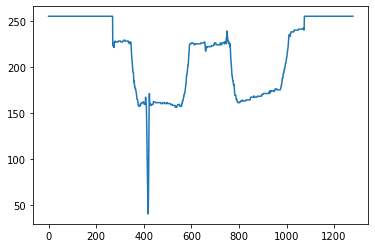

In [10]:
plt.plot(masked_image[700, :])

In [38]:
# since data is fairly sparse, we can do a median filter to determine the background
background = threshold_local(masked_image, block_size=31, method='median', )

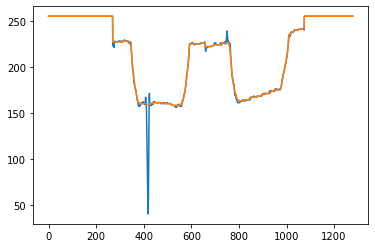

In [40]:
plt.plot(masked_image[700, :])
plt.plot(background[700, :])

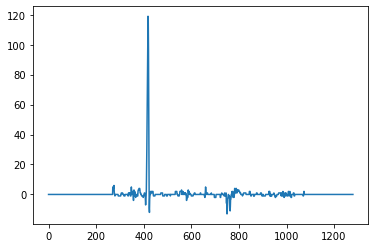

In [41]:
plt.plot((background - masked_image.numpy())[700, :])

In [42]:
median_thresholded_image = masked_image.numpy() < (background - 30)

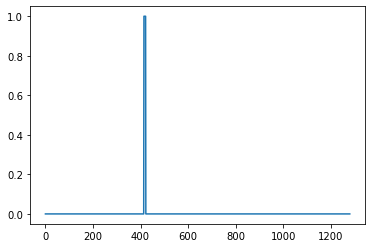

In [43]:
plt.plot(median_thresholded_image[700, :])

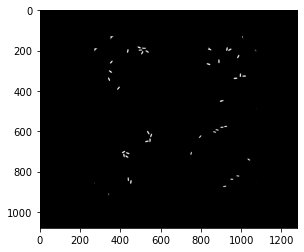

In [44]:
plt.imshow(median_thresholded_image, cmap='gray')

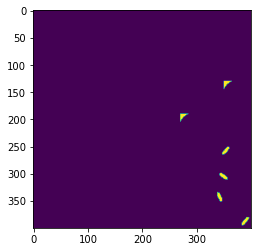

In [45]:
plt.imshow(median_thresholded_image[:400, :400])

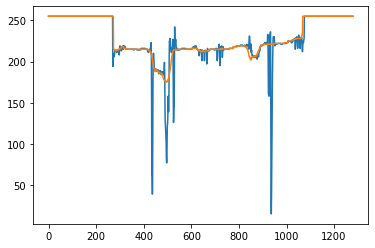

In [46]:
plt.plot(masked_image[200, :])
plt.plot(background[200, :])

Okay so some issues around the edges; we should probably calculate it before adding the mask:

In [69]:
# since data is fairly sparse, we can do a median filter to determine the background
background = threshold_local(image, block_size=31, method='median', )

In [70]:
background = test_mask(torch.tensor(background, dtype=torch.uint8), mask)

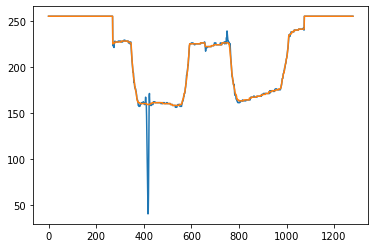

In [71]:
plt.plot(masked_image[700, :])
plt.plot(background[700, :])

In [74]:
median_thresholded_image = masked_image < (background - 30)

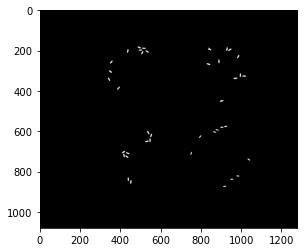

In [75]:
plt.imshow(median_thresholded_image, cmap='gray')

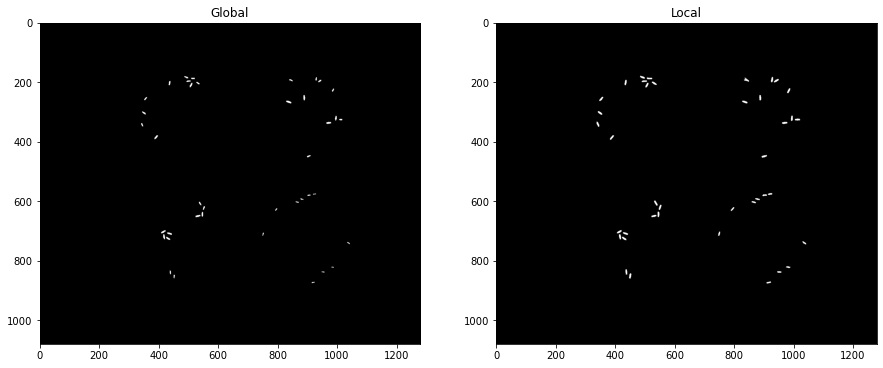

In [80]:
plt.figure(figsize=(15, 10))

plt.subplot(121)
plt.title("Global")
plt.imshow(thresholded_image, cmap='gray')

plt.subplot(122)
plt.title("Local")
plt.imshow(median_thresholded_image, cmap='gray')

In [5]:
def local_threshold(image, mask, threshold=30, block_size=31):
    background = threshold_local(image, block_size=block_size, method='median', )
    # we apply the mask after the background to avoid annoying edge effects
    background = test_mask(torch.tensor(background, dtype=torch.uint8), mask)
    return background - threshold

In [6]:
threshold = local_threshold(image, mask, 30, 31)

In [7]:
image = load_frame(movie_path, frame=500, color=False)
masked_image = test_mask(image, mask)

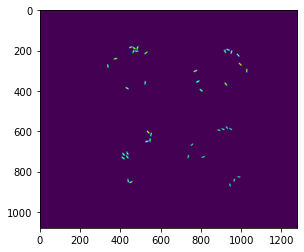

In [8]:
plt.imshow(test_threshold(masked_image, threshold))

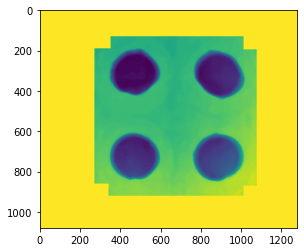

In [9]:
plt.imshow(threshold)

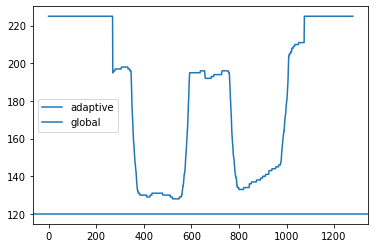

In [10]:
plt.plot(threshold[700], label='adaptive')
plt.axhline(120, label='global')

plt.legend()

Great so does this run??

In [11]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=True,
    parallel=False,
    n_ini=100,
    n_frames=1000,
    threshold=120,
)

Done with frame 0
Done with frame 1000
CPU times: user 1min 9s, sys: 163 ms, total: 1min 9s
Wall time: 4.77 s


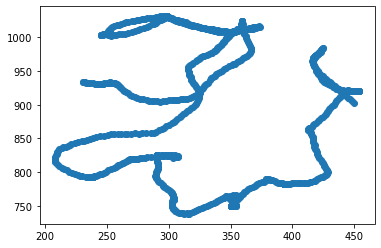

In [12]:
plt.plot(df.query('ID==30')["x"], df.query('ID==30')["y"], 'o--')

In [13]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=True,
    parallel=False,
    n_ini=100,
    n_frames=1000,
    threshold=threshold,
)

/home/gert-jan/Documents/flyTracker/src/flytracker/tracker.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold).to(device, non_blocking=True),


Done with frame 0
Done with frame 1000
CPU times: user 1min 12s, sys: 267 ms, total: 1min 12s
Wall time: 4.74 s


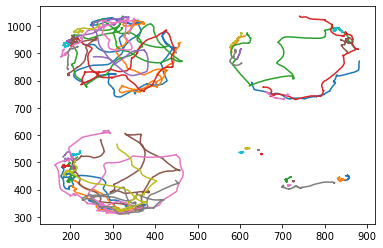

In [14]:
for ID in df.ID.unique():
    plt.plot(df.query(f'ID=={ID}')["x"], df.query(f'ID=={ID}')["y"])

Perfect :)

Does parallel still work?

In [15]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=True,
    parallel=True,
    n_ini=100,
    n_frames=1000,
    threshold=120,
)

Done with frame 0
Done with frame 1000
CPU times: user 58 s, sys: 328 ms, total: 58.4 s
Wall time: 5.79 s


In [16]:
%%time
df = run(
    movie_path,
    mask,
    n_arenas=4,
    gpu=True,
    parallel=True,
    n_ini=100,
    n_frames=1000,
    threshold=threshold,
)

/home/gert-jan/Documents/flyTracker/src/flytracker/tracker.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(threshold).to(device, non_blocking=True),


Done with frame 0
Done with frame 1000
CPU times: user 2min 54s, sys: 389 ms, total: 2min 54s
Wall time: 1min 20s
